In [ ]:
# TO DO:
# General: add second leg, etc.
# Rel Specific: recheck simplifications, benchmark

In [1]:
# DERIVE THE EOMs SYMBOLICALLY -------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np
import multiprocessing as mp #multiprocessing, just for the simplification steps
import time # for benchmarking different models

sym.init_printing()
from IPython.display import display #for pretty printing

# define non--program-critical functions
def log_time(t_start=None, msg=""):
    t_end = time.perf_counter()
    if t_start == None: print("Timer initialized")
    else: print(msg + f": {t_end - t_start:.6f} sec")
    return t_end

def mp_trigsimp(m):
    mp_data = [(m[r,c]) for r in range(m.rows) for c in range(m.cols)]
    if __name__ == '__main__':
        p = mp.Pool()
        results = p.map(sym.trigsimp, mp_data)
        p.close()
        p.join()
    return sym.Matrix(results).reshape(m.rows,m.cols)

# ------------------------------------------------------------------------------------------------------------------
# create symbolic variables

# system parameters 
g = sym.symbols('g')
m1, l1, In1, d1 = sym.symbols(['m_{1}','l_{1}','I_{1}','d_{1}'])
m2, l2, In2, d2 = sym.symbols(['m_{2}','l_{2}','I_{2}','d_{2}'])
m3, l3, In3, d3 = sym.symbols(['m_{3}','l_{3}','I_{3}','d_{3}'])
m4, l4, In4, d4 = sym.symbols(['m_{4}','l_{4}','I_{4}','d_{4}'])



# generalized coordinates
x  ,  dx,  ddx = sym.symbols([          'x',          '\dot{x}',          '\ddot{x}'])
y  ,  dy,  ddy = sym.symbols([          'y',          '\dot{y}',          '\ddot{y}'])
th1,dth1,ddth1 = sym.symbols(['\\theta_{1}','\dot{\\theta}_{1}','\ddot{\\theta}_{1}'])

sides = ['L','R']

th2 = [sym.symbols('\\theta_{2%s}'%s) for s in sides]
th3 = [sym.symbols('\\theta_{3%s}'%s) for s in sides]
th4 = [sym.symbols('\\theta_{4%s}'%s) for s in sides]

dth2 = [sym.symbols('\dot{\\theta}_{2%s}'%s) for s in sides]
dth3 = [sym.symbols('\dot{\\theta}_{3%s}'%s) for s in sides]
dth4 = [sym.symbols('\dot{\\theta}_{4%s}'%s) for s in sides]

ddth2 = [sym.symbols('\ddot{\\theta}_{2%s}'%s) for s in sides]
ddth3 = [sym.symbols('\ddot{\\theta}_{3%s}'%s) for s in sides]
ddth4 = [sym.symbols('\ddot{\\theta}_{4%s}'%s) for s in sides]

q   = sym.Matrix(  [x] +   [y] +   [th1] +   th2 +   th3 +   th4)
dq  = sym.Matrix( [dx] +  [dy] +  [dth1] +  dth2 +  dth3 +  dth4)
ddq = sym.Matrix([ddx] + [ddy] + [ddth1] + ddth2 + ddth3 + ddth4)


# ------------------------------------------------------------------------------------------------------------------
# functions, # don't ask, they work for the purposes of this program
def WeirdRot(v, th):
    # weird rotation function for working with [x; y; th] vectors
    # usage: gives R_1^0 transformation, and adds the angle of rotation to result
    R = sym.Matrix([[sym.cos(th), -sym.sin(th), 0],
                    [sym.sin(th),  sym.cos(th), 0],
                    [       0,        0, 1]])
    S = sym.Matrix([[0],[0],[th]])
    return R*v + S

def WeirdAdd(v1, v2):
    # returns the sum of two vectors of the form [x; y; th]
    # both in the same ref. frame, preserving only the first angle
    v3 = sym.Matrix([[1],[1],[0]])
    return v1 + sym.matrix_multiply_elementwise(v3, v2)

def WeirdTrans(v1, ang1, off1, ang2=0, off2=sym.Matrix([[0],[0],[0]])):
    # ^ & ^ just like me
    # transforms [x,y,th] vector to inertial frame using position offsets and
    # rotation angles as specified
    rn_m = WeirdAdd(WeirdRot(v1, ang1),off1)
    rn_0 = WeirdAdd(WeirdRot(rn_m, ang2),off2)
    return rn_0


# ------------------------------------------------------------------------------------------------------------------
# mass positions, foot positions
r1_1    = sym.Matrix([[0],[0],[0]]) #sanity check
r2_2    = sym.Matrix([[0],[-l2*d2],[0]])
r3_3    = sym.Matrix([[0],[-l3*d3],[0]])
r4_4    = sym.Matrix([[0],[-l4*d4],[0]]) # could define in x, but for consistency -y is fine
rfoot_4 = sym.Matrix([[0],[-l4]   ,[0]])

process_timer = log_time()

r1_0 = WeirdTrans(r1_1, th1, sym.Matrix([[x],[y],[0]]))
r2_0 = []
r3_0 = []
r4_0 = []
rfoot_0 = []

for i in range(len(sides)):
    r2_0.append(   WeirdTrans(   r2_2, th2[i], r1_1          , th1              , r1_0)) #sanity check
    r3_0.append(   WeirdTrans(   r3_3, th3[i], r2_2*(1-d2)/d2, th1+th2[i]       , r2_0[i]))
    r4_0.append(   WeirdTrans(   r4_4, th4[i], r3_3*(1-d3)/d3, th1+th2[i]+th3[i], r3_0[i]))
    rfoot_0.append(WeirdTrans(rfoot_4, th4[i], r3_3*(1-d3)/d3, th1+th2[i]+th3[i], r3_0[i])) #divide by d3 to get full link length

    r2_0[i]    = sym.trigsimp(   r2_0[i])
    r3_0[i]    = sym.trigsimp(   r3_0[i])
    r4_0[i]    = sym.trigsimp(   r4_0[i])
    rfoot_0[i] = sym.trigsimp(rfoot_0[i])

process_timer = log_time(process_timer, "Simplified 'r's")

# mass velocities, foot velocity
dr1 = r1_0.jacobian(q)*dq
dr2 = []
dr3 = []
dr4 = []
drfoot = []

for i in range(len(sides)):
    dr2.append(      r2_0[i].jacobian(q)*dq)
    dr3.append(      r3_0[i].jacobian(q)*dq)
    dr4.append(      r4_0[i].jacobian(q)*dq)
    drfoot.append(rfoot_0[i].jacobian(q)*dq)

# ------------------------------------------------------------------------------------------------------------------
# kinetic and potential energy
def Ep(m, r):
    return sym.Matrix([m*g*r[1]])

def Ek(m, In, dr):
    InM = sym.Matrix([[m,0,0],[0,m,0],[0,0,In]])
    return 0.5*dr.T*InM*dr

V = Ep(m1,r1_0)
T = [Ek(m1,In1,dr1)]

for i in range(len(sides)):
    V += Ep(m2,r2_0[i]) + Ep(m3,r3_0[i]) + Ep(m4,r4_0[i])
    
    T.append(Ek(m2,In2,dr2[i]))
    T.append(Ek(m3,In3,dr3[i]))
    T.append(Ek(m4,In4,dr4[i]))

T = sym.Matrix(T)
T = mp_trigsimp(T)
T = sum(T[i] for i in range(len(T)))
T = sym.Matrix([T])
process_timer = log_time(process_timer, "Simplified T")



# ------------------------------------------------------------------------------------------------------------------
# forces & torques
tau1 = sym.symbols(['\\tau_{1%s}'%s for s in sides])
tau2 = sym.symbols(['\\tau_{2%s}'%s for s in sides])
tau3 = sym.symbols(['\\tau_{3%s}'%s for s in sides])
GRFx = sym.symbols([    'G_{x%s}'%s for s in sides])
GRFy = sym.symbols([    'G_{y%s}'%s for s in sides])


tau1_l1, tau1_l2 = [],[]
tau2_l2, tau2_l3 = [],[]
tau3_l3, tau3_l4 = [],[]
GRF_r, GRFth, GRF_l4 = [],[],[]
Qtau1, Qtau2, Qtau3, QGRFs = [],[],[],[]
Qtot = sym.Matrix([[0],[0],[0],[0],[0],[0],[0],[0],[0]])

for i in range(len(sides)):
    tau1_l1.append(sym.Matrix([[0],[0],[-tau1[i]]]))
    tau1_l2.append(sym.Matrix([[0],[0], [tau1[i]]]))

    tau2_l2.append(sym.Matrix([[0],[0],[-tau2[i]]]))
    tau2_l3.append(sym.Matrix([[0],[0], [tau2[i]]]))

    tau3_l3.append(sym.Matrix([[0],[0],[-tau3[i]]]))
    tau3_l4.append(sym.Matrix([[0],[0], [tau3[i]]]))

    GRF_r.append(WeirdRot((1-d4)*rfoot_4, th1+th2[i]+th3[i]+th4[i]))
    GRFth.append(GRF_r[i][0]*GRFy[i] - GRF_r[i][1]*GRFx[i])
    GRF_l4.append(sym.Matrix([[GRFx[i]],[GRFy[i]],[GRFth[i]]]))

    Qtau1.append(     r1_0.jacobian(q).T*tau1_l1[i] + r2_0[i].jacobian(q).T*tau1_l2[i])
    Qtau2.append(  r2_0[i].jacobian(q).T*tau2_l2[i] + r3_0[i].jacobian(q).T*tau2_l3[i])
    Qtau3.append(  r3_0[i].jacobian(q).T*tau3_l3[i] + r4_0[i].jacobian(q).T*tau3_l4[i])
    QGRFs.append(rfoot_0[i].jacobian(q).T*GRF_l4[i])

    Qtot = Qtot + Qtau1[i] + Qtau2[i] + Qtau3[i] + QGRFs[i]

display(Qtot)
Qtot = mp_trigsimp(Qtot)
display(Qtot)
process_timer = log_time(process_timer, "Simplified Qtot")
# ------------------------------------------------------------------------------------------------------------------
# Mass, Gravity, Coriolis matrices, EOM
LgM = sym.hessian(T, dq)
LgM = mp_trigsimp(LgM)
process_timer = log_time(process_timer, "Simplified LgM")

LgG = V.jacobian(q)

dM = LgM.reshape(LgM.rows * LgM.cols, 1)
dM = dM.jacobian(q)*dq
dM = dM.reshape(LgM.rows, LgM.cols)
Tj = T.jacobian(q)
LgC = dM*dq - Tj.T

LgC = mp_trigsimp(LgC)
process_timer = log_time(process_timer, "Simplified LgC")

EOM = LgM*ddq + LgC + LgG.T - Qtot
EOM = mp_trigsimp(EOM)
process_timer = log_time(process_timer, "Simplified EOM")

Timer initialized
Simplified 'r's: 5.696589 sec
Simplified T: 69.726296 sec


⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢G_{xL}⋅l_{4}⋅(1 - d_{4})⋅cos(\theta_{1} + \theta_{2L} + \theta_{3L} + \theta_
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢G_{xL}⋅l_{4}⋅(1 - d_{4})⋅cos(\theta_{1} + \theta_{2L} + \theta_{3L} + \theta_
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

Simplified Qtot: 14.028691 sec
Simplified LgM: 27.528982 sec
Simplified LgC: 273.686549 sec
Simplified EOM: 423.628566 sec


In [ ]:
process_timer = log_time()
dM = LgM.reshape(LgM.rows * LgM.cols, 1)
dM = dM.jacobian(q)*dq
dM = dM.reshape(LgM.rows, LgM.cols)
dM = mp_trigsimp(dM)
process_timer = log_time(process_timer, "Simplified dM")
Tj = T.jacobian(q)
LgC = dM*dq - Tj.T

display(LgC)
LgC = mp_trigsimp(LgC)
display(LgC)
process_timer = log_time(process_timer, "Simplified LgC")

EOM = LgM*ddq + LgC + LgG.T - Qtot
EOM = mp_trigsimp(EOM)
process_timer = log_time(process_timer, "Simplified EOM")

In [ ]:
process_timer = log_time()
dM = LgM.reshape(LgM.rows * LgM.cols, 1)
dM = dM.jacobian(q)*dq
dM = dM.reshape(LgM.rows, LgM.cols)
Tj = T.jacobian(q)
Tj = mp_trigsimp(Tj)
process_timer = log_time(process_timer, "Simplified Tj")
LgC = dM*dq - Tj.T

display(LgC)
LgC = mp_trigsimp(LgC)
display(LgC)
process_timer = log_time(process_timer, "Simplified LgC")

EOM = LgM*ddq + LgC + LgG.T - Qtot
EOM = mp_trigsimp(EOM)
process_timer = log_time(process_timer, "Simplified EOM")

In [ ]:
process_timer = log_time()
dM = LgM.reshape(LgM.rows * LgM.cols, 1)
dM = dM.jacobian(q)*dq
dM = dM.reshape(LgM.rows, LgM.cols)
dM = mp_trigsimp(dM)
process_timer = log_time(process_timer, "Simplified dM")
Tj = T.jacobian(q)
Tj = mp_trigsimp(Tj)
process_timer = log_time(process_timer, "Simplified Tj")
LgC = dM*dq - Tj.T

display(LgC)
LgC = mp_trigsimp(LgC)
display(LgC)
process_timer = log_time(process_timer, "Simplified LgC")

EOM = LgM*ddq + LgC + LgG.T - Qtot
EOM = mp_trigsimp(EOM)
process_timer = log_time(process_timer, "Simplified EOM")

In [2]:
# simplification makes no changes:
# assuming all r's have been simplified
# dr, V, LgG

# pre-simplifying T for LgM does not appreciably change the total (T+LgM) simplification time
# pre-simplifying T and LgM for LgC significantly speeds up the total (T+LgM+LgC) simplification time (>30 min to <15 min)
# simplifying LgM and LgC significantly speeds up iterations below (1/2 iter/s to over 10 iter/sec)
# display(LgC)
display(EOM)

⎡                                                                             
⎢-G_{xL} - G_{xR} + \ddot{\theta}_{1}⋅(1.0⋅d_{2}⋅l_{2}⋅m_{2}⋅cos(\theta_{1} + 
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [3]:
# # LAMBDIFY ------------------------------------------------------------------------------------------------------------------    
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos}


sym_list = [g,
            m1 , m2, m3, m4,
            l1 , l2, l3, l4,
            In1,In2,In3,In4,
            d1 , d2, d3, d4,
            x  ,   y,  th1] +   th2 +   th3 +   th4 +\
            [dx,  dy, dth1] +  dth2 +  dth3 +  dth4 +\
            [ddx,ddy,ddth1] + ddth2 + ddth3 + ddth4 +\
            tau1 + tau2 + tau3 +\
            GRFx + GRFy

lamb_EOM  = {}

# DOFs
DOF0 = [('x','b'),('y','b'),('th1','b')]
DOF1 = ['th2','th3','th4']

DOFs  = [(  'x','b'),
         (  'y','b'),
         ('th1','b'),
         ('th2','L'),
         ('th2','R'),
         ('th3','L'),
         ('th3','R'),
         ('th4','L'),
         ('th4','R')]
TDOFs = ['x','y']

for dof_i, dof in enumerate(DOFs):
    lamb_EOM[dof]  = sym.lambdify(sym_list, EOM[dof_i],modules = [func_map])
    
lamb_footp = {}
lamb_footv = {}

for dof_i, dof in enumerate(TDOFs):
    for s_i, s in enumerate(sides):
        lamb_footp[dof,s]  = sym.lambdify(sym_list,rfoot_0[s_i][dof_i],modules = [func_map])
        print(lamb_footp[dof,s])
        print('')
        lamb_footv[dof,s]  = sym.lambdify(sym_list, drfoot[s_i][dof_i],modules = [func_map])

<function _lambdifygenerated at 0x7f3b559b2160>

<function _lambdifygenerated at 0x7f3b55a2f9d0>

<function _lambdifygenerated at 0x7f3b55a2f8b0>

<function _lambdifygenerated at 0x7f3b55a2fd30>



In [4]:
# PARAMETERS:
mass = {'b': 0.5,
       'l1': 0.2,
       'l2': 0.2,
       'l3': 0.1}

length = {'b': 1,
         'l1': 0.5,
         'l2': 0.5,
         'l3': 0.5}

dCOM = {'b': 0.5,
       'l1': 0.4,
       'l2': 0.4,
       'l3': 0.2}

inertia = {'b': mass['b']*length['b']**2/12,
          'l1': mass['l1']*length['l1']**2/12,
          'l2': mass['l2']*length['l2']**2/12,
          'l3': mass['l3']*length['l3']**2/12,}

links = ['b','l1','l2','l3']
joints = ['hip','knee','ankle']

def get_var_list(m,n):
    var_list = [m.g]+\
               [m.m[l] for l in links]+\
               [m.len[l] for l in links]+\
               [m.In[l] for l in links]+\
               [m.dCOM[l] for l in links]+\
               [m.q[n,dof] for dof in DOFs]+\
               [m.dq[n,dof] for dof in DOFs]+\
               [m.ddq[n,dof] for dof in DOFs]+\
               [m.tau[n,j,s] for s in sides for j in joints]+\
               [m.GRF[n,dof,s] for s in sides for dof in TDOFs]

    return var_list


In [36]:
def create_model(N,hm,mu):
    m = ConcreteModel()
    
    #SETS---------------------------------
    m.N =RangeSet(N)
    m.L =Set(initialize = links)
    m.J = Set(initialize = joints)
    m.DOF = Set(initialize= DOFs)
    m.TDOF = Set(initialize = TDOFs)
    m.S = Set(initialize = sides)
    
    #PARAMS-------------------------------
    m.g = Param(initialize = 9.81)
    m.mu = Param(initialize = mu)
    
    m.m = Param(m.L, initialize = mass)
    m.len = Param(m.L, initialize = length)
    m.In = Param(m.L, initialize = inertia)
    m.dCOM = Param(m.L, initialize = dCOM)
    
    
    signs = ['ps','ng']
    m.sgn = Set(initialize = signs)
    m.ground_constraints = ['contact','sliding_ps','sliding_ng']
    
    #VARIABLES----------------------------
    #gen coordinates
    m.q = Var(m.N,m.DOF)
    m.dq = Var(m.N,m.DOF)
    m.ddq = Var(m.N,m.DOF)
    
    #forces
    m.tau = Var(m.N,m.J   ,m.S)
    m.GRF = Var(m.N,m.TDOF,m.S)

# ------------------------------------------------------------------------------------------------------------------
    #TIME AND INTEGRATION

    # timestep
    m.hm = Param(initialize = hm, mutable = True) # master timestep
    m.h = Var(m.N, bounds = (0.8,1.0))
    
    # Integration constraints 
    def BwEuler_p(m,n,dof1,dof2): # for positions
        dof = (dof1,dof2)
        if n > 1:
            return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
        else:
            return Constraint.Skip 
    m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

    def BwEuler_v(m,n,dof1,dof2): # for velocities
        dof = (dof1,dof2)
        if n > 1:
            return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
        else:
            return Constraint.Skip 
    m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)
    
    def dynamics(m,n,dof1,dof2):
        dof = (dof1,dof2)
        var_list = get_var_list(m,n)
        temp = lamb_EOM[dof](*var_list) == 0
#         if temp in [None, True, False]:
#             return Constraint.Skip
#         else:
        return temp
    m.dynamics = Constraint(m.N,m.DOF, rule = dynamics)


# ------------------------------------------------------------------------------------------------------------------
    # Link Bounds ------------------------
    for n in range(1,N+1):
#         m.tau[n,'hip'].setlb(-20)
#         m.tau[n,'hip'].setub(20)
#         m.tau[n,'knee'].setlb(-10)
#         m.tau[n,'knee'].setub(10)
#         m.tau[n,'ankle'].setlb(-10)
#         m.tau[n,'ankle'].setub(10)
        m.q[n,  'x','b'].setlb(0.0)
        m.q[n,  'y','b'].setlb(0.0)
        m.q[n,'th1','b'].setlb(-np.pi/2)
        m.q[n,'th1','b'].setub(np.pi/2)
        for s in sides:
            # https://www.researchgate.net/figure/The-range-of-movements-in-the-hip-joint-a-flexion-extension-10-0-130_fig4_326636749
            m.q[n,'th2',s].setlb(-np.pi/2/9)
            m.q[n,'th2',s].setub(np.pi*3/4)
            #https://x10therapy.com/knee-range-of-motion/
            m.q[n,'th3',s].setlb(-np.pi*3/4)
            m.q[n,'th3',s].setub(0)
            #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4994968/
            m.q[n,'th4',s].setlb(np.pi/6)
            m.q[n,'th4',s].setub(np.pi*7/12)
            # ranges of motion above are temporary!!!
            m.GRF[n,'y',s].setlb(0)
        

    #Ground Constraints ------------------
    m.footp = Var(m.N, m.TDOF, m.S, bounds = (0.0,None))
    def def_footp(m,n,dof,s):
        var_list = get_var_list(m,n)
        return m.footp[n,dof,s] == lamb_footp[(dof,s)](*var_list)
    m.def_footp = Constraint(m.N, m.TDOF, m.S, rule = def_footp)
        
    m.footv = Var(m.N, m.TDOF, m.S, m.sgn, bounds = (0.0,None))
    def def_footv(m,n,dof,s,sgn):
        var_list = get_var_list(m,n)
        return m.footv[n,dof,s,'ps'] - m.footv[n,dof,s,'ng'] == lamb_footv[(dof,s)](*var_list)
    m.def_footv = Constraint(m.N, m.TDOF, m.S, m.sgn, rule = def_footv)
    





    m.alpha = Var(m.N, m.S, bounds = (0,1))
    def friction(m,n,s):
        if n == 1:
            return Constraint.Skip
        return m.GRF[n,'x',s] == (1 - 2*m.alpha[n,s])*m.mu*m.GRF[n,'y',s]
    m.friction = Constraint(m.N, m.S, rule = friction)
    
    m.ground_penalty = Var(m.N, m.S, m.ground_constraints, bounds = (0.0,None))
    def ground_complementarity(m,n,s,gc):
        if n == 1:
            return Constraint.Skip
        if gc == 'contact':
            A = m.GRF[n,'y',s]
            B = m.footp[n,'y',s] + m.footv[n,dof,s,'ps'] + m.footv[n,dof,s,'ng']
            
        if gc == 'sliding_ps':
            A = 1 - m.alpha[n,s]
            B = m.footv[n,dof,s,'ps']
            
        if gc == 'sliding_ng':
            A = m.alpha[n,s]
            B = m.footv[n,dof,s,'ng']
        
        return A*B <= m.ground_penalty[n,s,gc]
    m.ground_complementarity = Constraint(m.N, m.S, m.ground_constraints, rule = ground_complementarity)
 



    # OBJECTIVES -----------------------------------------------------------------------------------------------------------
    def MinPenalty(m):
        return sum([m.ground_penalty[n,s,gc] for n in range(1,N+1) for s in m.S for gc in m.ground_constraints])
    m.MinPenalty = Objective(rule = MinPenalty)
    
    return m


In [6]:
def init_opt(max_iter, max_time): # initializes solver
    opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
    opt.options["linear_solver"] = 'ma97'
    opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
    opt.options["max_iter"] = max_iter # maximum number of iterations
    opt.options["max_cpu_time"] = max_time # maximum cpu time in seconds
    opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
    opt.options["OF_acceptable_obj_change_tol"] = 1e-4
    opt.options["OF_ma86_scaling"] = 'none'
    
    return opt


In [30]:
# HIGH DROP -----------------------------------------------------------------------------------------------------------------

def high_drop(m):
    # initial condition
    for dof in DOFs:
        #m.ddq[1,dof].fix(0)
        m.dq[ 1,dof].fix(0) # rest
        m.q[  1,dof].fix(0) # neutral posture
    m.q[1,'y','b'].unfix()
    for s in sides:
        m.q[1,'th4',s].unfix()
        m.q[1,('th4',s)].fix(np.pi/3)
        m.footp[1,'y',s].fix(10)
    
    # during
    for n in range(1,N+1):
        for s in sides:
            for j in joints:
                m.tau[n,j,s].fix(0)

    return m

In [31]:
# LOW DROP ------------------------------------------------------------------------------------------------------------------

def low_drop(m):
    # initial condition
    for dof in DOFs:
        m.ddq[1,dof].fix(0)
        m.dq[ 1,dof].fix(0) # rest
        m.q[  1,dof].fix(0) # neutral posture
    m.q[1,'y','b'].unfix()
    for s in sides:
        m.q[1,'th4',s].unfix()
        m.footp[1,'y',s].setlb(0.1) # start near the ground

    # during
    for n in range(1,N+1):
        for s in sides:
            for j in joints:
                m.tau[n,j,s].fix(0) # no forces
            if n > 15:
                m.footp[15,'y',s].fix(0) # force it to land
    return m

In [32]:
# # # STANDING ------------------------------------------------------------------------------------------------------------------
def standing(m):
    # initial condition
    for dof in DOFs:
        m.dq[1,dof].fix(0) # rest
        m.q[ 1,dof].fix(0) # neutral posture
    m.q[1,'y','b'].unfix()
    for s in sides:
        m.q[1,'th4',s].unfix()

    # during
    for n in range(1,N+1):
        for s in sides:
            m.footp[n,'y',s].fix(0) # must stay grounded for the full time

    # final condition (hold)
    for n in range(N-20,N+1):
        for dof in DOFs:
            m.dq[n,dof].fix(0)
        m.q[n,'th1','b'].fix(0)
    
    return m

In [52]:
# # HIGH DROP + NUDGE ---------------------------------------------------------------------------------------------------------

def bounce(m):
    for dof in DOFs:
        m.dq[1,dof].fix(0)
    m.q[1,'x','b'].fix(0)
    for s in sides:
        m.footp[1,'y',s].fix(0)
        
    # middle
    for s in sides:
        m.footp[15,'y',s].setlb(0.2)
        for n in range(1,N+1):
            m.footp[n,'x',s].setlb(-0.5)
            m.footp[n,'x',s].setub(0.5)
    
    # end
    for n in range(N-10,N+1):
        for dof in DOFs:
            m.dq[n,dof].fix(0)
        m.q[n,'th1','b'].fix(0)
        for s in sides:
            m.footp[n,'y',s].fix(0)
                
    return m

In [57]:
N = 50
hm = 0.02
mu = 1.0
m = create_model(N,hm,mu)

# m = high_drop(m)
# m = low_drop(m)
# m = standing(m)
m = bounce(m)

opt = init_opt(30000,3000)
results = opt.solve(m,tee=True)


Ipopt 3.13.4: linear_solver=ma97
print_level=5
max_iter=30000
max_cpu_time=3000
Tol=1e-06
option_file_name=/tmp/tmp12pav8xt_ipopt.opt

Using option file "/tmp/tmp12pav8xt_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver ma97.

Number of nonzeros in equality constraint Jacobian...:    16205
Number of nonzeros in inequality constraint Jacobian.:     1056
Number of nonzeros in Lagrangian Hessian.............:     7029

Total number of variables............................:     2753
                     variables with only lower bounds:      975
                variables with lower and upp

In [58]:
# if the problem is infeasible, this is how you can see which constraints weren't satisfied
from pyomo.util.infeasible import log_infeasible_constraints
log_infeasible_constraints(m)

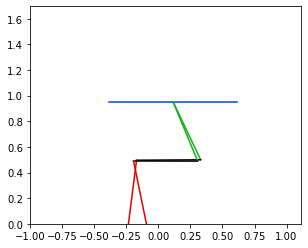

In [59]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

xmax = np.max([m.q[n,'x','b'].value for n in range(1,N+1)])
ymax = np.max([m.q[n,'y','b'].value for n in range(1,N+1)])

def plot_model(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,xmax+1]) # adjust limits to solution
    ax.set_ylim([0,ymax+0.5])
    
    #plot body
    body_xb = m.q[i,'x','b'].value - 0.5*m.len[('b')]*cos(m.q[i,'th1','b'].value)
    body_yb = m.q[i,'y','b'].value - 0.5*m.len[('b')]*sin(m.q[i,'th1','b'].value)
    body_xf = m.q[i,'x','b'].value + 0.5*m.len[('b')]*cos(m.q[i,'th1','b'].value)
    body_yf = m.q[i,'y','b'].value + 0.5*m.len[('b')]*sin(m.q[i,'th1','b'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:blue')
    
    for s in sides:
        #plot thighs
        thA = m.q[i,'th1','b'].value+m.q[i,'th2',s].value
        leg1_xt = m.q[i,'x','b'].value
        leg1_yt = m.q[i,'y','b'].value
        leg1_xb = m.q[i,'x','b'].value + m.len[('l1')]*sin(thA)
        leg1_yb = m.q[i,'y','b'].value - m.len[('l1')]*cos(thA)
        ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:green')

        #plot calves
        thB = m.q[i,'th1','b'].value+m.q[i,'th2',s].value+m.q[i,'th3',s].value
        leg2_xt = leg1_xb
        leg2_yt = leg1_yb
        leg2_xb = leg1_xb + m.len[('l2')]*sin(thB)
        leg2_yb = leg1_yb - m.len[('l2')]*cos(thB)
        ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:black')

        #plot feet
        thC = m.q[i,'th1','b'].value+m.q[i,'th2',s].value+m.q[i,'th3',s].value+m.q[i,'th4',s].value
        leg3_xt = leg2_xb
        leg3_yt = leg2_yb
        leg3_xb = leg2_xb + m.len[('l3')]*sin(thC)
        leg3_yb = leg2_yb - m.len[('l3')]*cos(thC)
        ax.plot([leg3_xt,leg3_xb],[leg3_yt,leg3_yb],color='xkcd:red')
    
update = lambda i: plot_model(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [ ]:
m.GRF.pprint()

In [1]:
m.q[50,:,:].pprint()

NameError: name 'm' is not defined